# **Elementary Trading Algorithms and Backtesting (WORK IN PROGRESS)**

**NOTE:** This project may take significant time to complete due to circumstances beyond the author's control.

## **Contents**
1) [Introduction](#Introduction)
2) [Moving Average Strategy](#Moving-Average-Strategy)
3) [Bollinger Bands Strategy](#Bollinger-Bands-Strategy)
4) [Fibonacci Retracement Strategy](#Fibonacci-Retracement-Strategy)
5) [Credits](#Credits)

## **Introduction**
The purpose of this project is to formulate and backtest some basic trading algorithms using Python, in order to evaluate their performance. The `time`, `datetime`, `numpy`, `scipy`, `pandas`, `matplotlib`, `seaborn`, `yfinance`, `pypfopt`, `riskfolio` and `warnings` libraries are imported. Moreover, the plot styles are adjusted for aesthetic reasons and some warnings are ignored for readability (as of the time of conception, all warnings encountered in this project were warnings about deprecated features that are not used in this project).

In [35]:
import time as tm
import datetime as dt
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pypfopt as ppf
import riskfolio as rsk
import warnings as wrn

palette = sns.color_palette("viridis_r", as_cmap = True)
sns.set_style(style = "whitegrid", rc = {"font.family" : "Times New Roman", "font.weight" : "bold"})
wrn.simplefilter(action = 'ignore', category = FutureWarning)

A couple of remarks are in order:
- The benchmark used to evaluate the performance of the trading algorithms is the buy-and-hold strategy over a specified time frame;
- The metric used to evaluate the performance of the trading algorithms is the cumulative return generated by the trading strategies;
- Monthly portfolio rebalancing will be applied at the beginning of each month via inverse-volatility weighting;
- Other metrics of interest which are calculated include annualized expected return, annualized volatility, annualized Sharpe ratio, Value-at-Risk (VaR) and Expected Shortfall (ES), and;
- No part of this project is intended to be financial advice, and the reader is kindly implored not to interpret it as such. On the other hand, the reader is strongly encouraged to make informed decisions and be aware of the risks involved with trading in the financial markets.

## **Moving Average Strategy**
The moving average strategy is a trend-following strategy which aims to detect whether a trend exists in the price of financial assets over a specified time frame and take a position according to this trend. The indicator used to determine whether or not a trend exists is a pair of moving averages over specified lookback windows: one lookback window representing a shorter-term trend, and another lookback window representing the longer term trend. The trading signals of this strategy are generated as follows:
- If the shorter-term moving average exceeds the longer-term moving average, take a long position in the financial asset(s) in question, and;
- If the shorter-term moving average falls short of the longer-term moving average, take a short position in the financial asset(s) in question.

The Python implementation of this trading algorithm is found in the code cell below:

In [42]:
def moving_average_strategy(tickers, start_date, end_date, short_window = 5, long_window = 15, weights = None, request = None):
    assert 1 < short_window < long_window, "Lookback windows must be longer than one period and the long window must exceed the short window."
    if len(tickers) == 1:
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df = pd.DataFrame({
            "Date" : df.index,
            "Portfolio" : df.values
        }).set_index("Date")
    else:
        if weights is None:
            n = len(tickers)
            weights = np.ones(n) / n
        else:
            assert len(tickers) == len(weights), "There must be as many assets as weights"
            assert sum(weights) == 1, "The portfolio must be capital budgeted, meaning that all weights must sum up to 1"
        df = yf.download(tickers = tickers, start = start_date, end = end_date, progress = False)["Close"]
        df["Portfolio"] = np.dot(weights, df.T)
        df["Shorter-Term"] = df["Portfolio"].rolling(short_window).mean()
        df["Longer-Term"] = df["Portfolio"].rolling(long_window).mean()
        df["Signal"] = 0
        df.loc[df["Shorter-Term"] > df["Longer-Term"], "Signal"] = 1
        df.loc[df["Shorter-Term"] < df[f"Longer-Term"], "Signal"] = -1
        df["Position"] = df["Signal"].diff()
        df["Month"] = df.groupby(df.index.to_period('M')).ngroup() + 1
        df["Month-Change"] = df["Month"].diff()
        df["Log-Returns"] = np.log(df["Portfolio"]).diff()
        df["Cumulative Log-Returns"] = np.exp(df["Log-Returns"]).cumprod()
        df["Strategy Log-Returns"] = df["Signal"] * df["Log-Returns"]
        df["Strategy Cumulative Log-Returns"] = np.exp(df["Strategy Log-Returns"]).cumprod()
        if request is None:
            return df
        else:
            assert request in ["Metrics", "Visualisation", "Backtesting"], "The request must be one of \"Metrics\", \"Visualisation\" and \"Backtesting\"."
            return df

df = moving_average_strategy(["AAPL", "MSFT"], "2020-01-01", "2024-01-01")

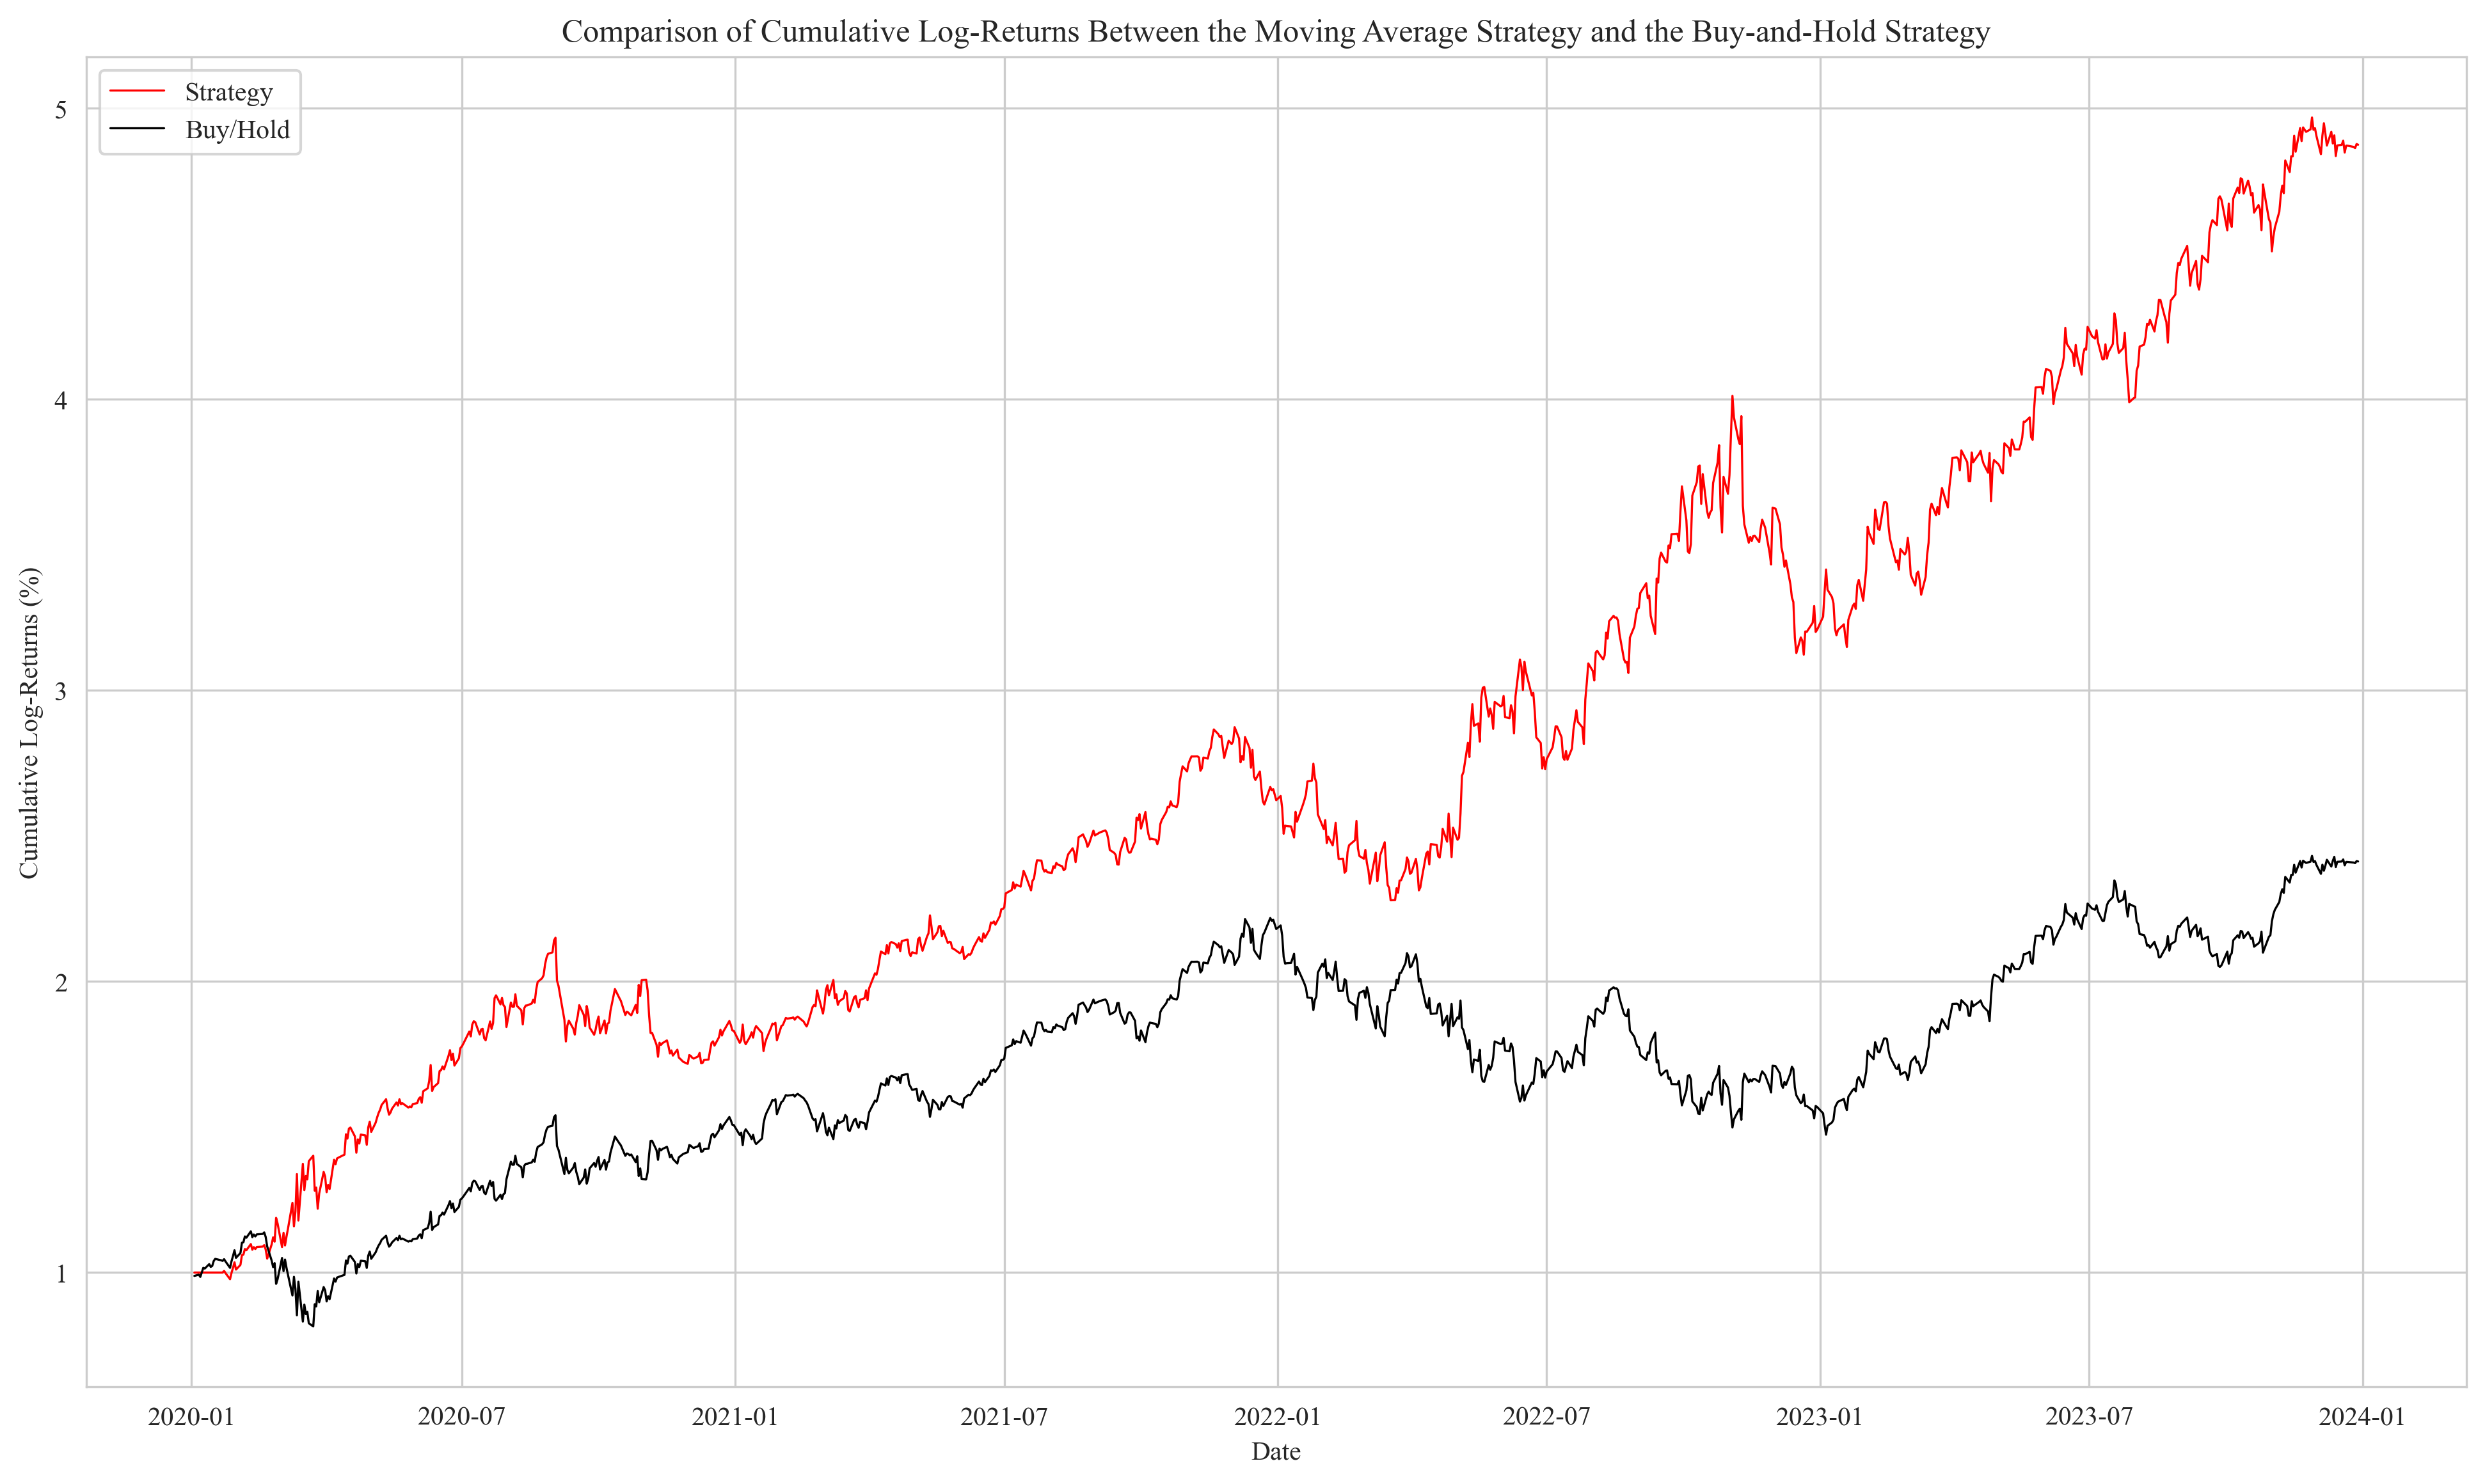

In [44]:
plt.figure(figsize = (16, 9), dpi = 300)
sns.lineplot(data = df, x = "Date", y = "Strategy Cumulative Log-Returns", label = "Strategy", linewidth = 0.8, color = "red")
sns.lineplot(data = df, x = "Date", y = "Cumulative Log-Returns", label = "Buy/Hold", linewidth = 0.8, color = "black")
plt.xlabel("Date")
plt.ylabel("Cumulative Log-Returns (%)")
plt.title("Comparison of Cumulative Log-Returns Between the Moving Average Strategy and the Buy-and-Hold Strategy")
plt.legend()
plt.show()

## **Credits**
1) [Chainika Thakar - *Moving Average Trading Strategies: Triple Crossover, Ribbon, and Convergence Divergence Explained*](https://blog.quantinsti.com/moving-average-trading-strategies/)
2) [Chainika Thakar and Rekhit Pachanekar - *Bollinger Bands Explained: Trading Strategy, Formula, Calculation and More*](https://blog.quantinsti.com/bollinger-bands/)
3) [QuantInsti - *Fibonacci Retracement: Trading Strategy, Python implementation, and more*](https://blog.quantinsti.com/fibonacci-retracement-trading-strategy-python/)
4) [Matt Macarty - *Introduction to Algorithmic Trading Using Python - How to Create & Test Trading Algorithm*](https://www.youtube.com/watch?v=fqltiq5EahU)
5) The original code is provided as-is in this project by Zakaria Zerrouki 